In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My\ Drive 

/content/gdrive/My Drive


# 1. Importation des librairies


In [3]:
from keras.applications.xception import Xception, preprocess_input
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import math
import numpy as np
import os
import argparse
import matplotlib
import imghdr
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle as pkl
import datetime

Using TensorFlow backend.


# 2. Génération des données à partir de chemins

In [0]:
def generate_from_paths_and_labels(input_paths, labels, batch_size, input_size=(299,299)):

    num_samples = len(input_paths)
    while 1:
        perm = np.random.permutation(num_samples)
        input_paths = input_paths[perm]
        labels = labels[perm]
        for i in range(0, num_samples, batch_size):
            inputs = list(map(
                lambda x: image.load_img(x, target_size=input_size),
                input_paths[i:i+batch_size]
            ))
            inputs = np.array(list(map(
                lambda x: image.img_to_array(x),
                inputs
            )))
            inputs = preprocess_input(inputs)
            yield (inputs, labels[i:i+batch_size])

# 3. Définition des paramètres

In [0]:
# paramètres
lr_pre=1e-3
lr_fine=1e-4
epochs_pre=5
epochs_fine = 5
batch_size_pre=8
batch_size_fine=8
model_name = "huge.h5"
dataset_path = "data_huge"
result_path = "results"
save_path= "epochs"
classes_path = "classes.txt"
snapshot_period_pre=1
snapshot_period_fine=1

# 4. Récupérer les images ainsi que leurs classes

In [0]:
# Récupurer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# Récupurer les images et les classes
input_paths, labels = [], []
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    class_id = classes.index(class_name)
    for path in os.listdir(class_path):
        path = os.path.join(class_path, path)
        if imghdr.what(path) == None:
            # this is not an image file
            continue
        input_paths.append(path)
        labels.append(class_id)

#Note:
- **input_path** et **labels** contiennent respectivement les chemins des images *(input_path)* et la classe à laquelle chacune de ces images appartient *(labels)*.



# 5. Préparer les données

In [7]:
#build covertor dict
#convertor = {}
#for i, classe in enumerate(classes):
#  one_hot = [0. for i in range(num_classes)]
#  one_hot[i] = 1.0
#  print(classe)
#  convertor[classe] = one_hot
  
#temp = labels

# convert labels to one-hot-vector format
#for i, label in enumerate(labels):
#  labels[i] = convertor[label]

labels = np_utils.to_categorical(labels)

print(labels)


# convert input paths to numpy array
input_paths = np.array(input_paths)

# shuffle dataset (permuter les données)
perm = np.random.permutation(len(input_paths))
labels = labels[perm]
input_paths = input_paths[perm]

# split dataset for training and validation
border = int(len(input_paths) * 0.8)
train_labels, val_labels = labels[:border], labels[border:]
train_input_paths, val_input_paths = input_paths[:border], input_paths[border:]
print("Training on %d images and labels" % (len(train_input_paths)))
print("Validation on %d images and labels" % (len(val_input_paths)))

# Création du dossier pour sauvegrader le model
if os.path.exists(result_path) == False:
    os.makedirs(result_path)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Training on 13373 images and labels
Validation on 3344 images and labels


# 6. Choix et création du classifieur

In [8]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3))  # La pouvez tester différentes architectures

# create a custom top classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

83689472/83683744 [==============================] - 2s 0us/step


# 7. Entrainer le modèle

In [0]:
train_generator = generate_from_paths_and_labels(train_input_paths, train_labels, batch_size_fine )
val_generator = generate_from_paths_and_labels( val_input_paths, val_labels, batch_size_fine )

In [0]:
# ====================================================
# Train the whole model
# ====================================================
# set all the layers to be trainable
for layer in model.layers:
    layer.trainable = False

# recompiler
optimizer = Adam(lr=0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Lancer l'entrainement
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, 'pre_epoch_{epoch}'))
callback_list = [checkpointer]
history_pre = model.fit_generator(train_generator, epochs=epochs_pre,
                                  steps_per_epoch=len(train_input_paths)/batch_size_pre, callbacks=callback_list,
                                  validation_data= val_generator, validation_steps=len(val_input_paths)/batch_size_fine )

# Sauvegarder le modèle (model.save)
model_file = os.path.join(result_path, model_name)
model.save(model_file)

Epoch 1/5
1672/1671 [==============================] - 1745s 1s/step - loss: 0.9751 - acc: 0.7074 - val_loss: 1.0618 - val_acc: 0.3227
Epoch 2/5
1672/1671 [==============================] - 357s 213ms/step - loss: 0.9760 - acc: 0.7058 - val_loss: 1.0619 - val_acc: 0.3221
Epoch 3/5
1671/1671 [============================>.] - ETA: 0s - loss: 0.9757 - acc: 0.7056

In [47]:
# ====================================================
# Train the whole model
# ====================================================
# set all the layers to be trainable
for layer in model.layers:
    layer.trainable = True

# recompiler
optimizer = Adam(lr=0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Lancer l'entrainement
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, 'fine_epoch_{epoch}'))
callback_list = [checkpointer]
history_fine = model.fit_generator(train_generator, epochs=epochs_fine,
                                   steps_per_epoch=len(train_input_paths)/batch_size_fine, callbacks=callback_list,
                                   validation_data= val_generator, validation_steps=len(val_input_paths)/batch_size_fine )

# Sauvegarder le modèle (model.save)
model_file = os.path.join(result_path, model_name)
model.save(model_file)

Epoch 1/5
150/150 [==============================] - 133s 890ms/step - loss: 0.2184 - acc: 0.9600 - val_loss: 0.0263 - val_acc: 0.9967
Epoch 2/5
150/150 [==============================] - 112s 745ms/step - loss: 0.9329 - acc: 0.8917 - val_loss: 1.4234 - val_acc: 0.8933
Epoch 3/5
150/150 [==============================] - 111s 743ms/step - loss: 0.4701 - acc: 0.9200 - val_loss: 0.0348 - val_acc: 0.9900
Epoch 4/5
150/150 [==============================] - 111s 741ms/step - loss: 0.3830 - acc: 0.9500 - val_loss: 0.4476 - val_acc: 0.8800
Epoch 5/5
150/150 [==============================] - 111s 743ms/step - loss: 0.3635 - acc: 0.9292 - val_loss: 0.0675 - val_acc: 0.9967


# 8. Créer et afficher les résultats

In [0]:
# concatinate plot data
acc = history_pre.history['acc']
val_acc = history_pre.history['val_acc']
loss = history_pre.history['loss']
val_loss = history_pre.history['val_loss']
acc.extend(history_fine.history['acc'])
val_acc.extend(history_fine.history['val_acc'])
loss.extend(history_fine.history['loss'])
val_loss.extend(history_fine.history['val_loss'])

In [36]:
# ====================================================
# Create & save result graphs
# ====================================================


# save graph image
plt.plot(range(epochs_fine+epochs_pre), acc, marker='.', label='acc')
plt.plot(range(epochs_fine+epochs_pre), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig(os.path.join(result_path, 'acc.png'))
plt.show()
plt.clf()

plt.plot(range(epochs_fine+epochs_pre), loss, marker='.', label='loss')
plt.plot(range(epochs_fine+epochs_pre), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(os.path.join(result_path, 'loss.png'))
plt.show()
plt.clf()

# save plot data as pickle file
plot = {
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
}
with open(os.path.join(result_path, 'plot.dump'), 'wb') as f:
    pkl.dump(plot, f) 

# 9. Tester le modèle

In [49]:
from keras.applications.xception import (
    Xception, preprocess_input, decode_predictions
)
from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import os
import cv2 

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

%matplotlib inline

model_path="results/small.h5"   # Ici, vous devez indiquer votre modèle
classes_path = "classes.txt"
image_path="images_test/feu3.jpg"         # Votre image de test   
top_n=3
model = load_model(model_path)

# load class names
classes = []
with open(classes_path, 'r') as f:
    classes = list(map(lambda x: x.strip(), f.readlines()))

# load an input image
img = image.load_img(image_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# predict
pred = model.predict(x)[0]
result = [(classes[i], float(pred[i]) * 100.0) for i in range(len(pred))]
result.sort(reverse=True, key=lambda x: x[1])

img = cv2.imread(image_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.rectangle(img, (200,200), (800,500), (0,0,0), 4)

font = cv2.FONT_HERSHEY_COMPLEX 

for i in range(top_n):
    (class_name, prob) = result[i]
    if (i == 0) :
        cv2.putText(img, class_name, (250, 400), font, 5, (255,0,0), 6, cv2.LINE_AA)
    print("Top %d ====================" % (i + 1))
    print("Class name: %s" % (class_name))
    print("Probability: %.2f%%" % (prob))
plt.imshow(img)

KeyboardInterrupt: ignored

Top 1 ====================
Class name: fire
Probability: 100.00%
Top 2 ====================
Class name: no_fire
Probability: 0.00%
Top 3 ====================
Class name: start_fire
Probability: 0.00%

Top 1 ====================
Class name: fire
Probability: 100.00%
Top 2 ====================
Class name: start_fire
Probability: 0.00%
Top 3 ====================
Class name: no_fire
Probability: 0.00%

Top 1 ====================
Class name: fire
Probability: 100.00%
Top 2 ====================
Class name: no_fire
Probability: 0.00%
Top 3 ====================
Class name: start_fire
Probability: 0.00%

Top 1 ====================
Class name: fire
Probability: 100.00%
Top 2 ====================
Class name: start_fire
Probability: 0.00%
Top 3 ====================
Class name: no_fire
Probability: 0.00%

Top 1 ====================
Class name: fire
Probability: 100.00%
Top 2 ====================
Class name: no_fire
Probability: 0.00%
Top 3 ====================
Class name: start_fire
Probability: 0.

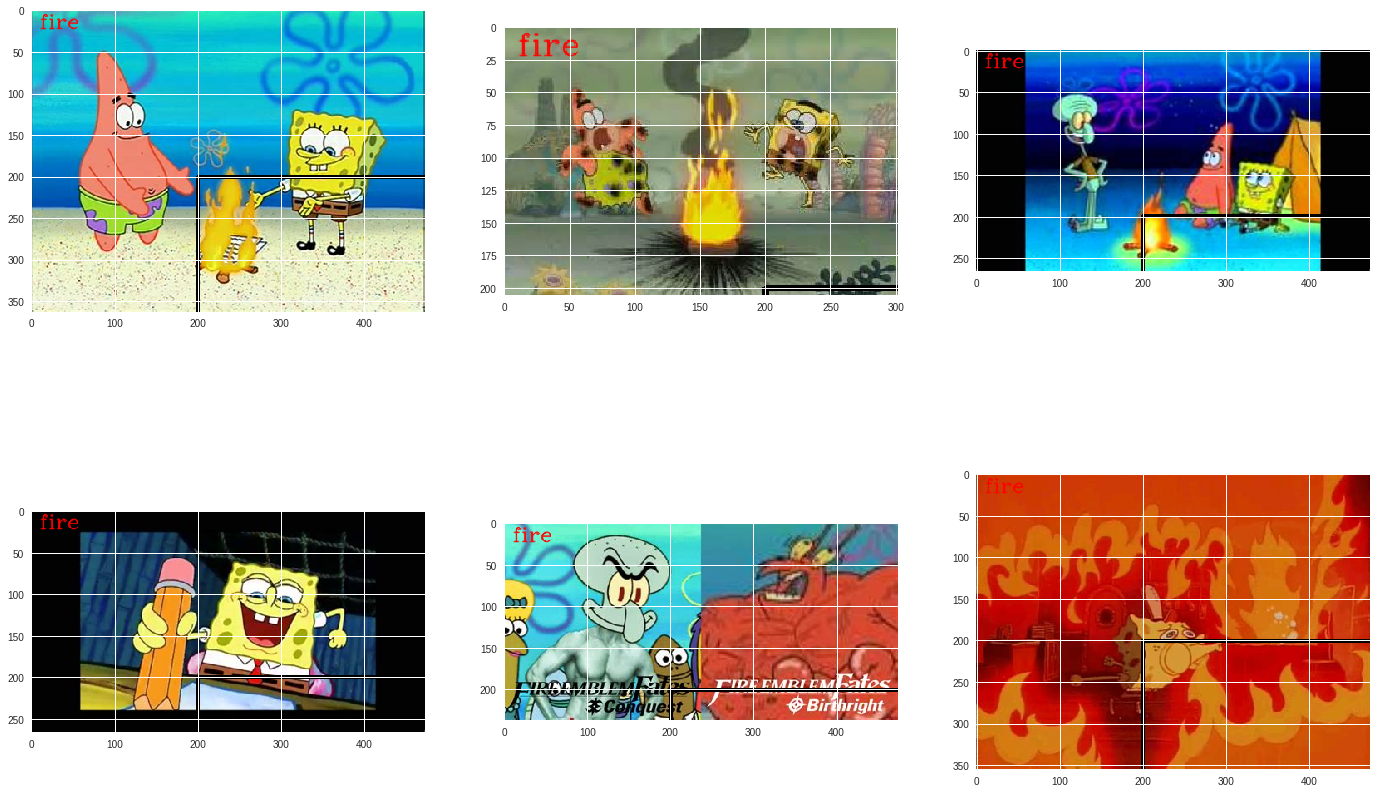

In [41]:
from keras.applications.xception import (
    Xception, preprocess_input, decode_predictions
)
from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import os
import cv2
import math

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

%matplotlib inline

model_path="results/small.h5"   # Ici, vous devez indiquer votre modèle
classes_path = "classes.txt"
image_paths = [
    os.path.join('SpongeTest', image_name)
    for image_name in sorted(os.listdir('SpongeTest'))
]
num_images = len(image_paths)
top_n=3
model = load_model(model_path)

# load class names
classes = []
with open(classes_path, 'r') as f:
    classes = list(map(lambda x: x.strip(), f.readlines()))

# load an input image
x_test = []
for image_path in image_paths:
  img = image.load_img(image_path, target_size=(299, 299))
  x = image.img_to_array(img)
  
  x_test.append(preprocess_input(x))
x_test = np.array(x_test)

# predict
predictions = model.predict(x_test)
results = []
for pred in predictions:
  result = [(classes[i], float(pred[i]) * 100.0) for i in range(len(pred))]
  result.sort(reverse=True, key=lambda x: x[1])
  results.append(result)

# Read the images.
images = []
for image_path in image_paths:
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.rectangle(img, (200,200), (800,500), (0,0,0), 4)
  images.append(img)

fig = plt.figure(figsize=(24, 24))
plot_size = math.ceil(math.sqrt(num_images))
font = cv2.FONT_HERSHEY_COMPLEX 
for j, (img, result) in enumerate(zip(images, results)):
  for i in range(top_n):
      (class_name, prob) = result[i]
      if (i == 0) :
          cv2.putText(img, class_name, (10, 22), font, 0.8, (255, 0, 0), 1, cv2.LINE_AA)
      print("Top %d ====================" % (i + 1))
      print("Class name: %s" % (class_name))
      print("Probability: %.2f%%" % (prob))
  print()
  plt.subplot(plot_size, plot_size, (j + 1))
  plt.imshow(img)
plt.show()